# 3. BenMAP health impact analysis



The public health impact by the CCS technology is computed using BenMAP program, which is developed and maintained by U.S. EPA. The health impact analysis is race/ethnicity statified, in order to explore the impact of CCS technology on environmental justice. 


1. spatial distribution of actual values
2. spatial distribution of normalized values (by race/ethinicity population by county)
3. national sum of each endpoint by race-ethinicity
4. LA state sum of each endpoint by race-ethinictiy 
5. LA state sum of each endpoint (normalized by the corresponding population ) by race-ethinictiy


#### Note that only "Emergency Room Visits  Asthma" has ethinicity separate (for White population), so I will merge them into just "White". 
## Population data is from INMAP (2013 population with race)

In [1]:
import geopandas as gpd
import pandas as pd
import os
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt



# Function to subset data for a specific state or use national data
def subset_data(final_df, state_fips=None):
    if state_fips:
        return final_df[final_df['STATE_FIPS'] == state_fips]
    return final_df

# Function to plot bar plots
def plot_bar(df, y_column, group_col, title, output_dir):
    plt.figure(figsize=(12, 8))

    # Create the barplot
    ax = sns.barplot(data=df, x='Endpoint', y=y_column, hue=group_col)
    
    # Set title and labels
    plt.title(title)
    plt.ylabel('Sum of ' + y_column)
    plt.xlabel('Endpoint')
    
    # Use symlog scale for y-axis
    plt.yscale('symlog')
    plt.legend(title=group_col)
    
    # Add value annotations on top of the bars
    for p in ax.patches:
        value = p.get_height()
        if abs(value) < 0.01:
            annotation = f'{value:.3f}'
        elif abs(value) < 1:
            annotation = f'{value:.2f}'
        else:
            annotation = f'{int(value)}'
        ax.annotate(annotation, (p.get_x() + p.get_width() / 2., value),
                    ha='center', va='baseline')

    # Rotate the x-tick labels for better readability
    plt.xticks(rotation=90)

    # Add vertical gridlines between each category
    for i in range(len(ax.get_xticks())):
        ax.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=0.8)
    
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

    plt.savefig(os.path.join(output_dir, f'{y_column}_{TARGET_GRID_LEVEL}_{title}_.png'), dpi=300, bbox_inches='tight')
    plt.show()


# Creating a pretty table with plotly
def pretty_create_table(df, columns, title):
    formatted_values = [format_values(df[col]) for col in columns]
    fig = go.Figure(data=[go.Table(
        header=dict(values=columns,
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=formatted_values,
                   fill_color='lavender',
                   align='left'))
    ])
    fig.update_layout(title_text=title)
    file_path = os.path.join(output_dir, f'{TARGET_GRID_LEVEL}_{title}.png')
    fig.write_image(file_path, format='png', scale=2, engine='kaleido')
    fig.show()

# Example function to format values
def format_values(value):
    return f'{value:.4g}' if isinstance(value, (int, float)) else value

# Function to create and save a table as CSV
def create_csv(df, columns, title, output_dir):
    # Format the values in the DataFrame
    formatted_df = df[columns].applymap(format_values)
    
    # Create the file path
    file_path = os.path.join(output_dir, f'{TARGET_GRID_LEVEL}_{title}.csv')
    
    # Save the DataFrame to CSV
    formatted_df.to_csv(file_path, index=False)
    
    print(f"CSV file saved at {file_path}")


# Function to plot spatial distribution for each race on the same page using the same color scale
def plot_spatial_distribution_combined(gdf, title, y_axis, output_dir):
    unique_races = gdf['Race'].unique()
    n_races = len(unique_races)
    fig, axes = plt.subplots(1, n_races, figsize=(5 * n_races, 8), sharex=True, sharey=True)
    fig.suptitle(title)

    vmin, vmax = gdf[y_axis].min(), gdf[y_axis].max()
    max_abs = max(abs(vmin), abs(vmax)) * 0.8

    if n_races == 1:
        axes = [axes]  # Make axes iterable if there is only one subplot

    for ax, race in zip(axes, unique_races):
        race_gdf = gdf[gdf['Race'] == race]
        race_gdf.plot(column=y_axis, cmap='coolwarm', vmin=-max_abs, vmax=max_abs, legend=False, ax=ax)
        ax.set_title(f'{race}')

        # Calculate the sum of the values in the domain
        if y_axis == "Mean_per_Pop":
            total_sum = race_gdf["Mean"].sum() / race_gdf["Population"].sum() * 1000000
            # Add the sum as text within the subplot
            ax.text(0.5, -0.1, f'Sum: {total_sum:.2f}', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')
        else:  
            total_sum = race_gdf[y_axis].sum()
            # Add the sum as text within the subplot
            ax.text(0.5, -0.1, f'Sum: {total_sum:.2f}', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')

    # Add a single color bar
    cbar_ax = fig.add_axes([0.95, 0.15, 0.1, 0.7])
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-max_abs, vmax=max_abs))
    sm._A = []
    fig.colorbar(sm, cax=cbar_ax)

    plt.savefig(os.path.join(output_dir, f'{y_axis}_{TARGET_GRID_LEVEL}_{title}.png'), dpi=300, bbox_inches='tight')
    plt.show()


##############
# STEP 1: get BenMAP grid shapefile
##############

# Define file paths

TARGET_GRID_LEVEL = 'County'

if TARGET_GRID_LEVEL == 'County':

    grid_shapefile_path = '/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/grids/County/County.shp'
    grid_gdf = gpd.read_file(grid_shapefile_path)

elif TARGET_GRID_LEVEL == 'Tract':

    ## TODO - add BenMAP tract shapefile to get Row and Col information

    grid_shapefile_path = '/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/grids/US Census Tracts/US Census Tracts.shp'
    grid_gdf = gpd.read_file(grid_shapefile_path)

# Rename Columns
grid_gdf.rename( columns={"COL":"Col", "ROW": "Row"}, inplace=True)



/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_92116/273108093.py:19: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  benmap = pd.read_csv(benmap_output_file)


Processing data for: LA
                  Endpoint Pollutant     Author Race STATE_FIPS CNTY_FIPS  \
1079  Mortality  All Cause     PM2.5  Di et al.  ALL         22       001   
1080  Mortality  All Cause     PM2.5  Di et al.  ALL         22       003   
1081  Mortality  All Cause     PM2.5  Di et al.  ALL         22       005   
1082  Mortality  All Cause     PM2.5  Di et al.  ALL         22       007   
1083  Mortality  All Cause     PM2.5  Di et al.  ALL         22       009   

      Row  Col      Mean    Population  \
1079    1   22  0.181944   9874.500977   
1080    3   22  0.172505   4071.125000   
1081    5   22  0.514258  17177.894531   
1082    7   22 -0.147783   4415.304688   
1083    9   22  0.102663   7359.593262   

                                               geometry  
1079  POLYGON ((-92.62786 30.25861, -92.62403 30.258...  
1080  POLYGON ((-92.92060 30.43811, -92.93478 30.438...  
1081  POLYGON ((-91.00071 30.07411, -91.00575 30.079...  
1082  POLYGON ((-91.09530 29

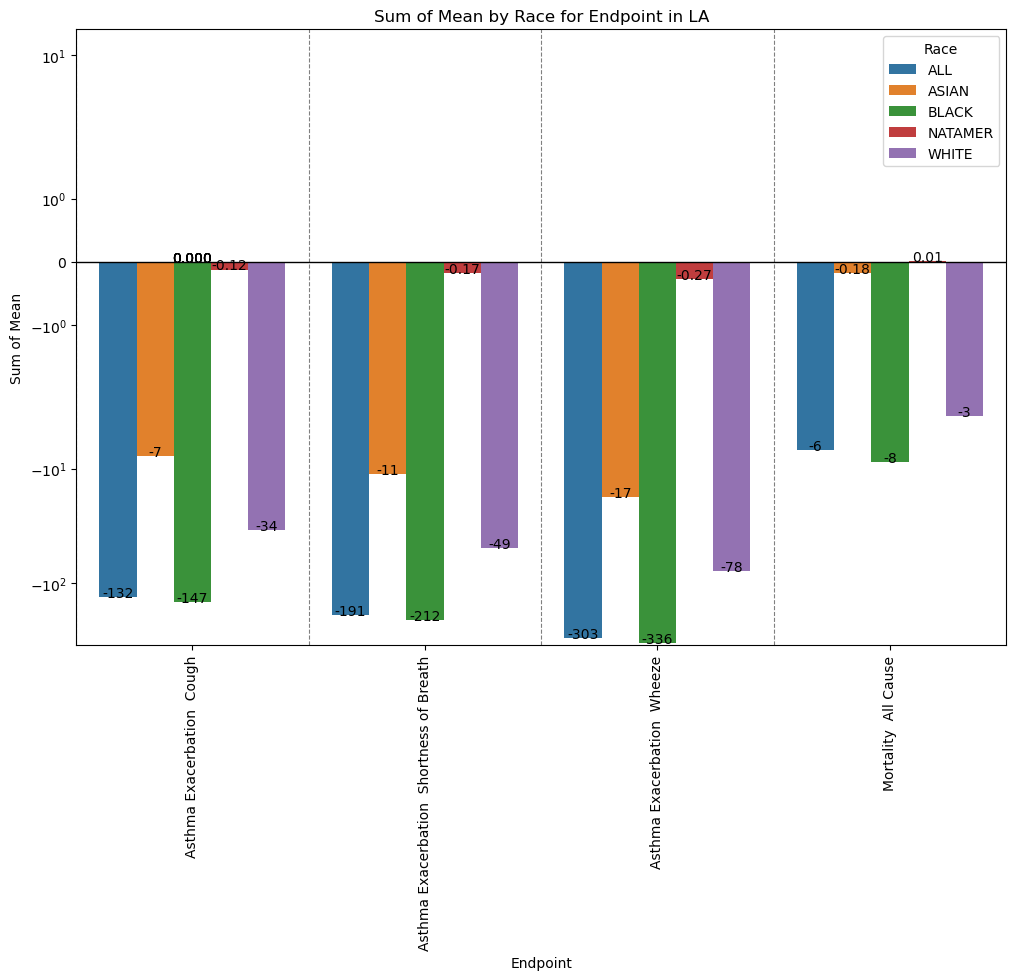

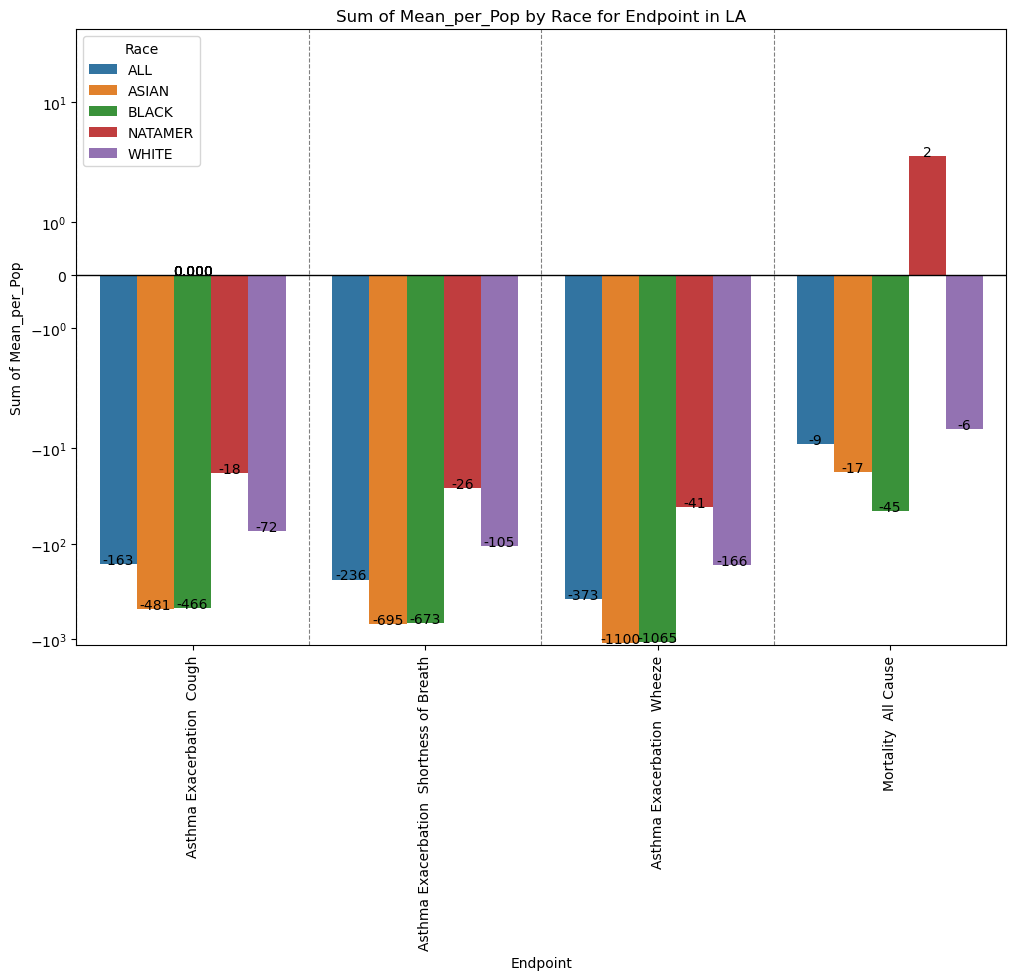

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_92116/2385064045.py:82: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = df[columns].applymap(format_values)


CSV file saved at /Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/BenMAP/batchmode/incidence_results/County_Summary Table: Mean and Mean per Population by Race in LA.csv


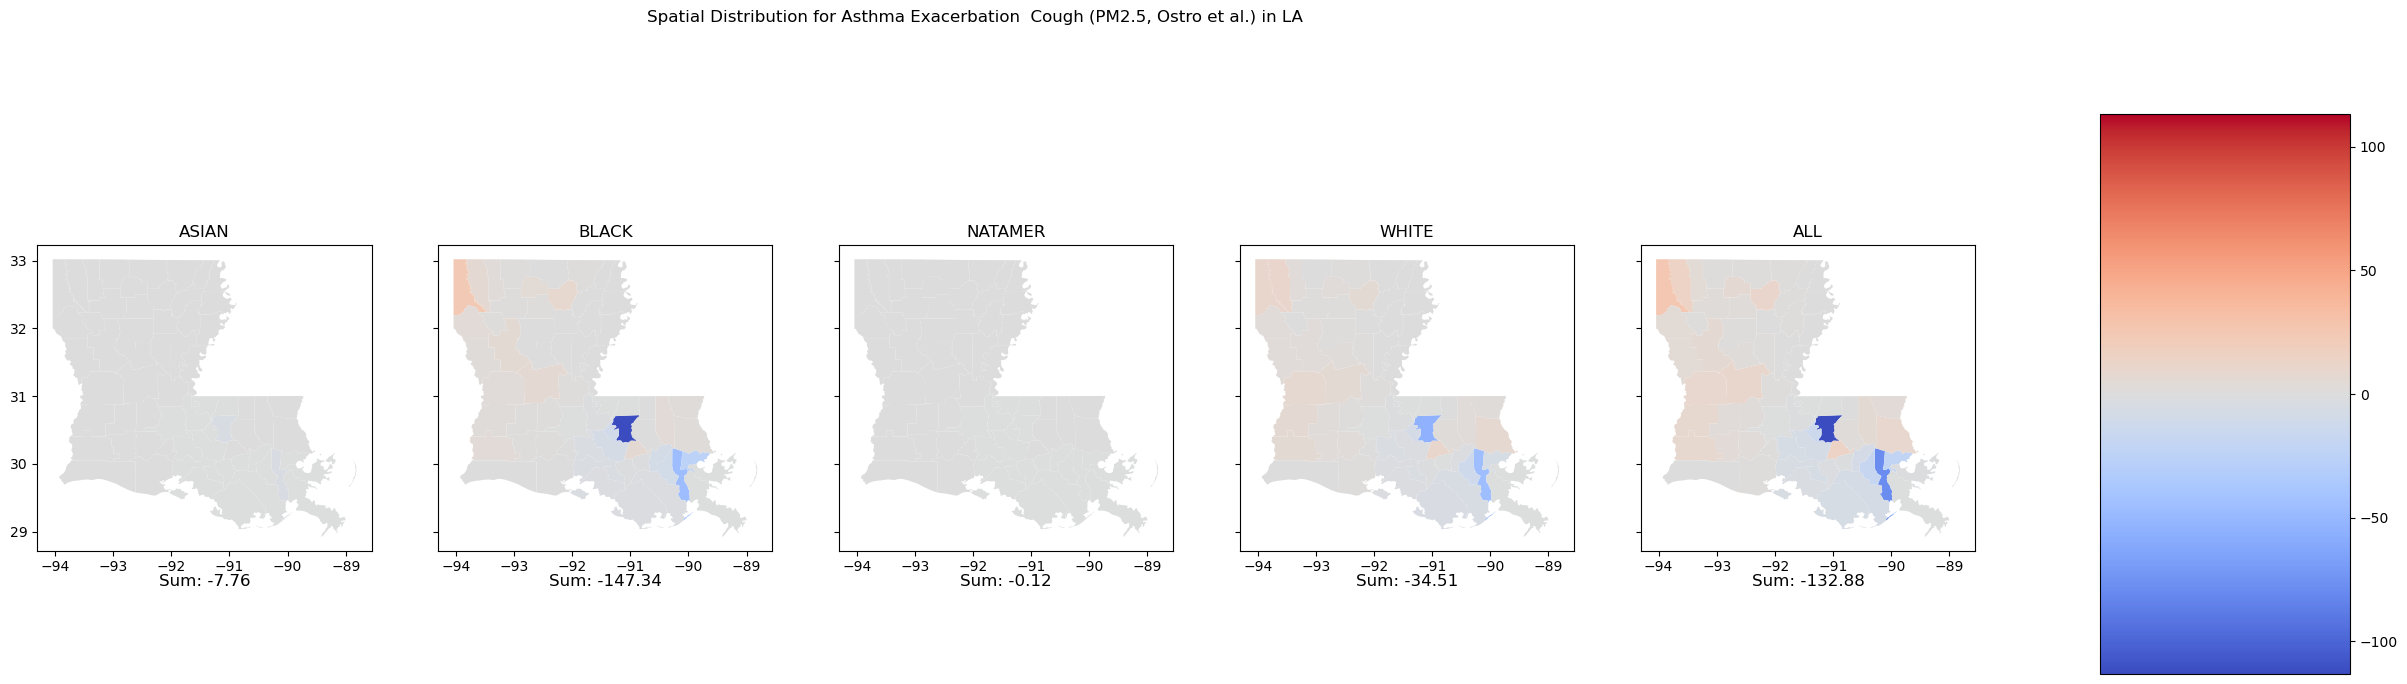

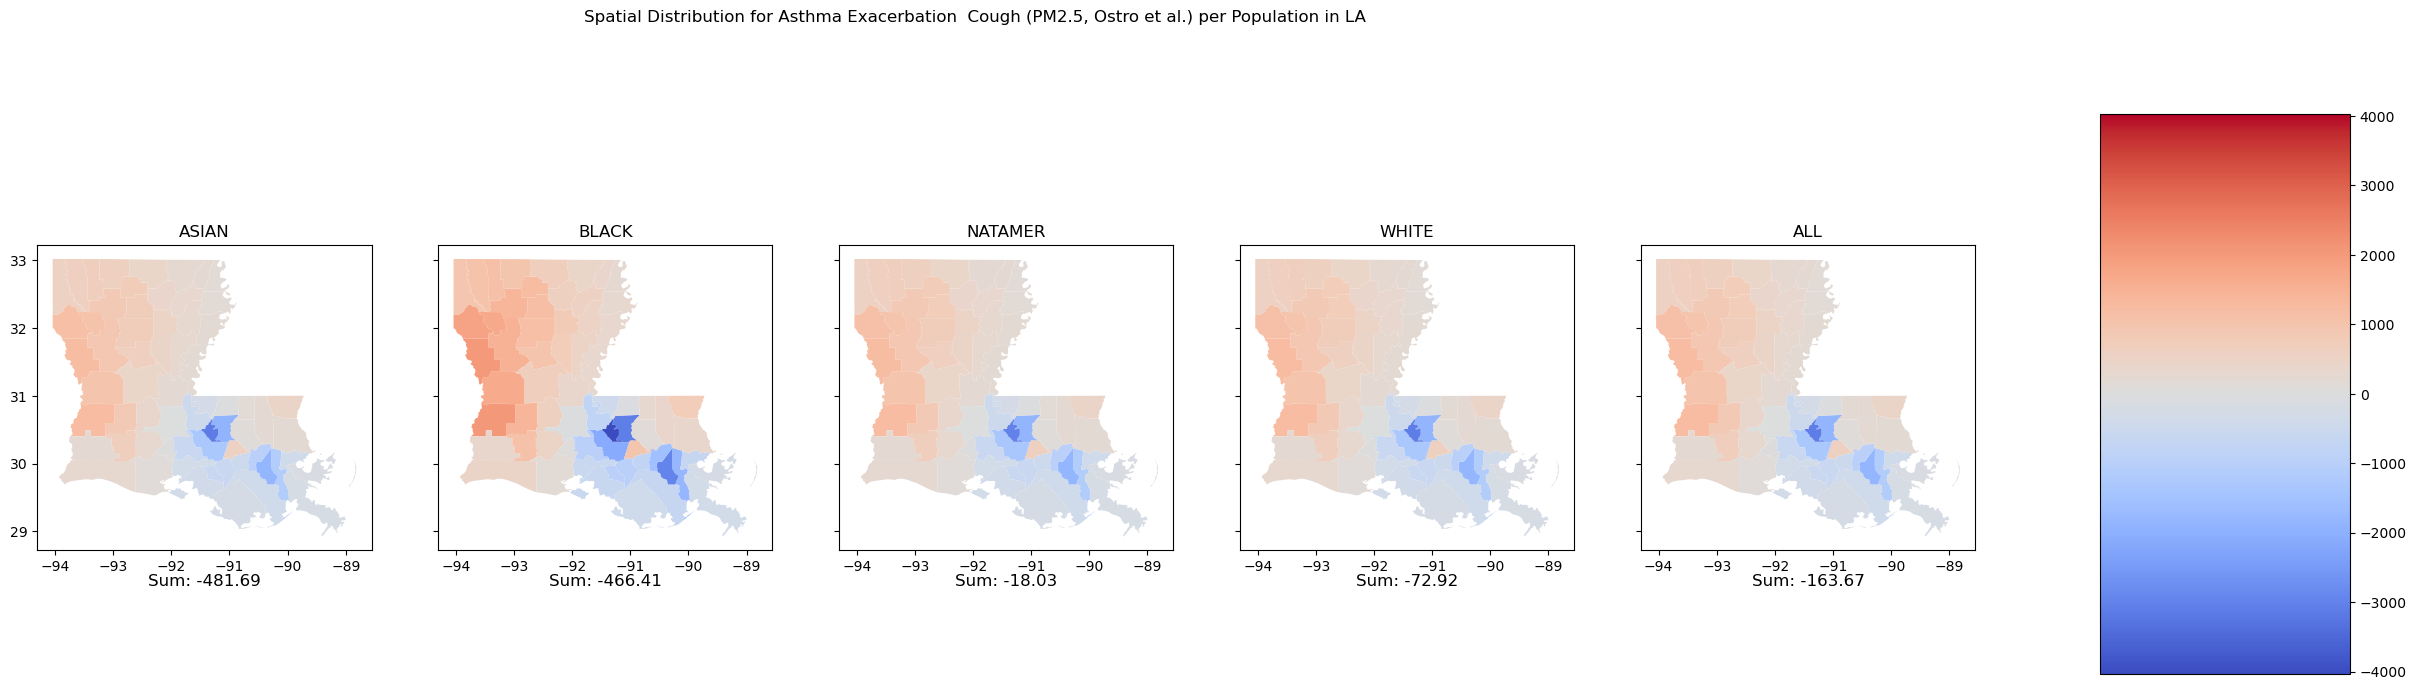

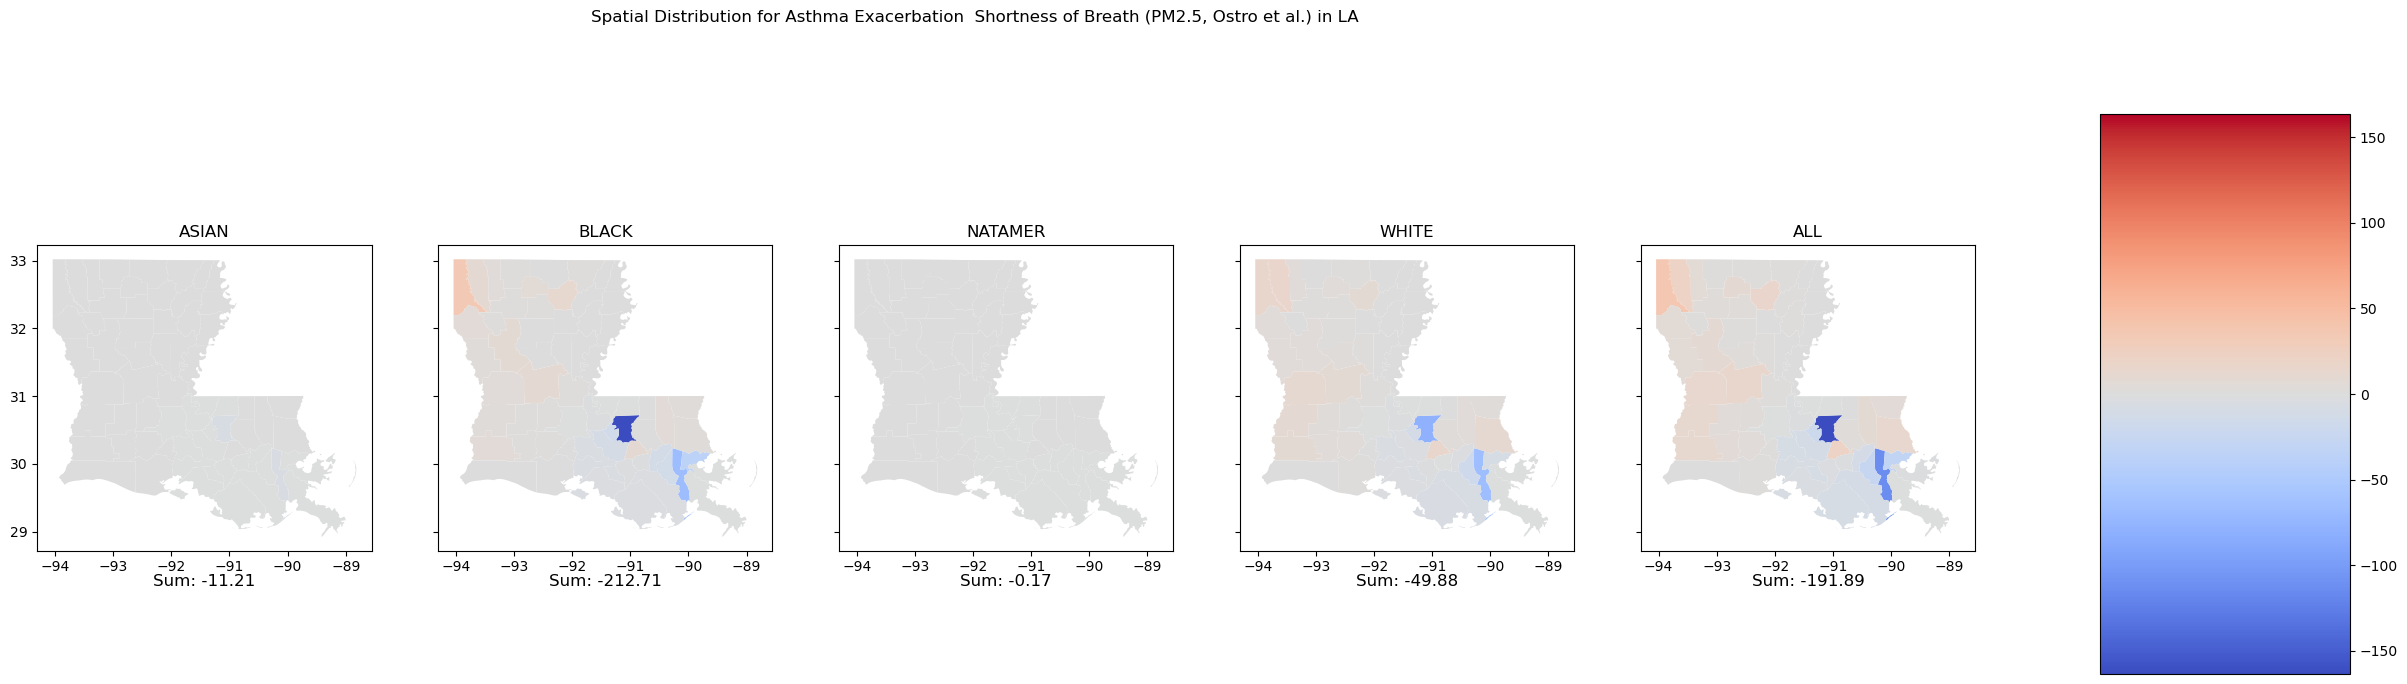

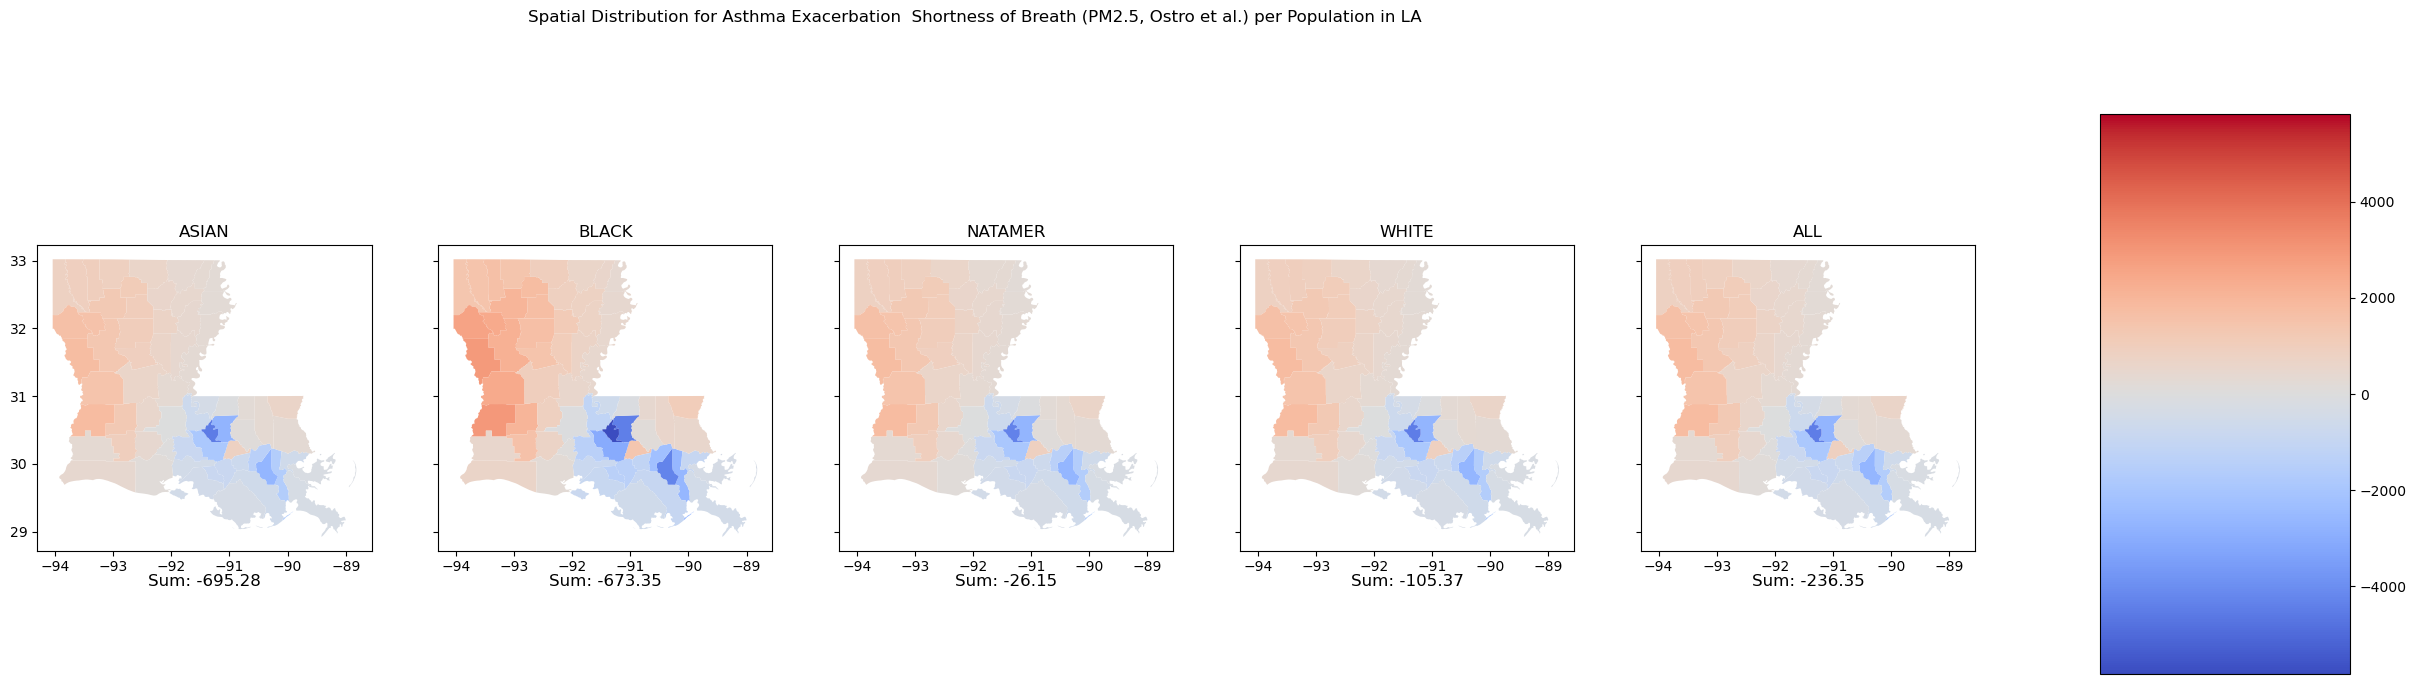

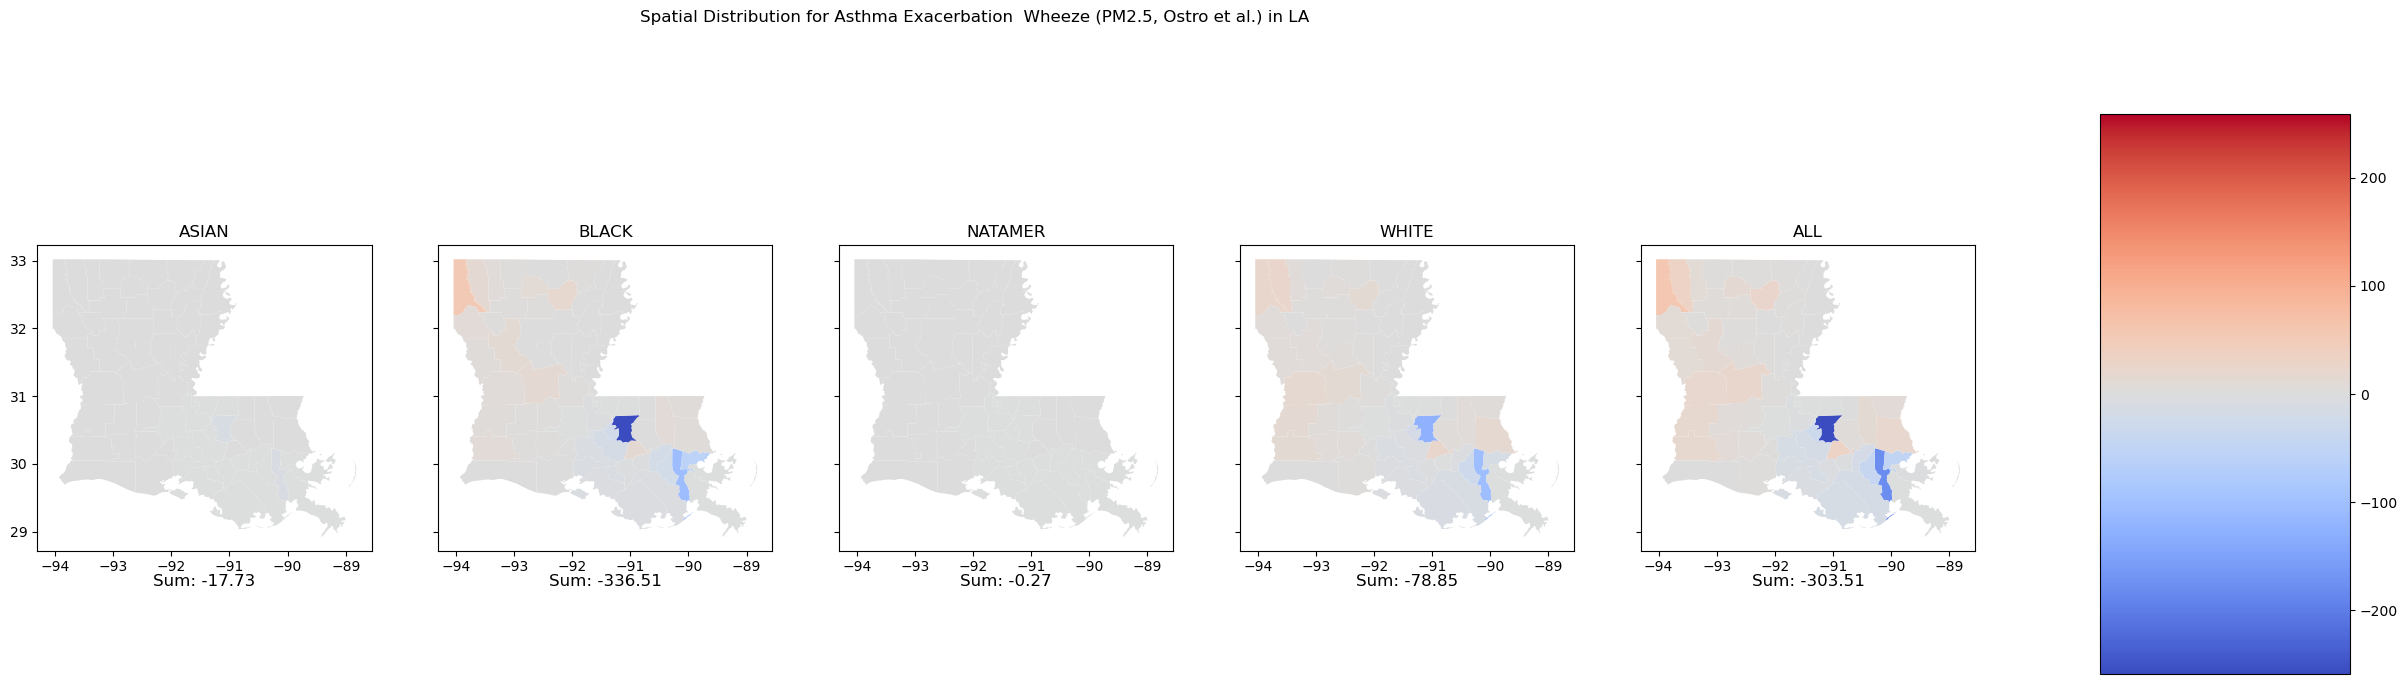

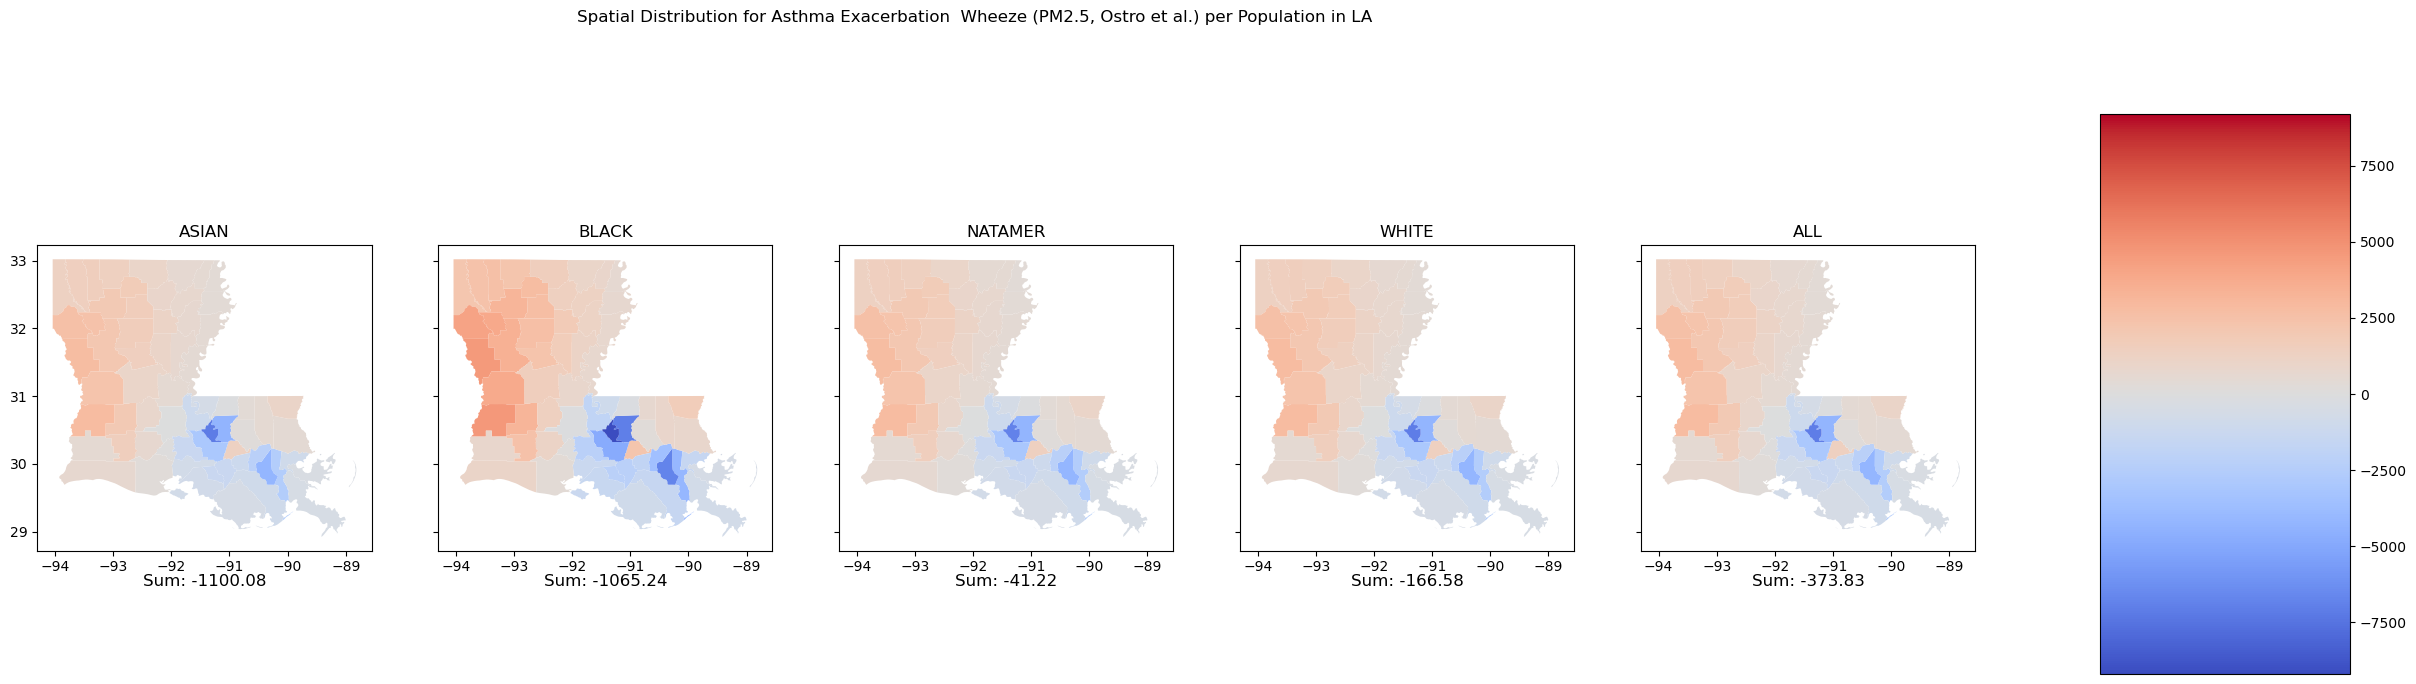

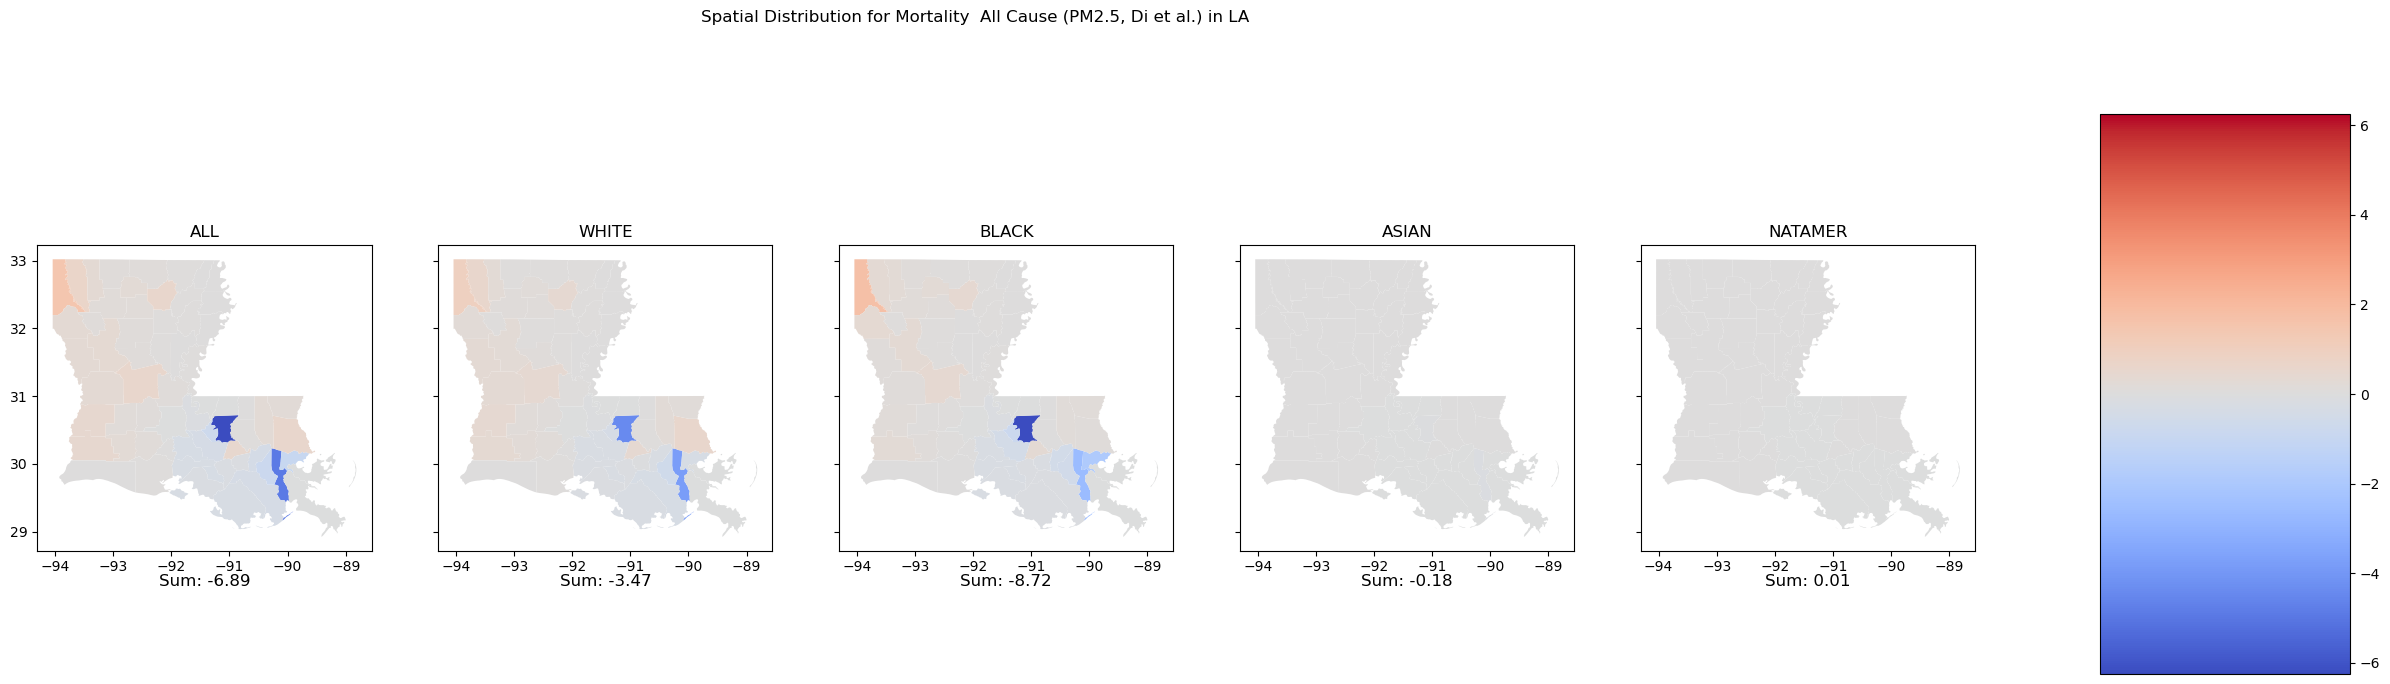

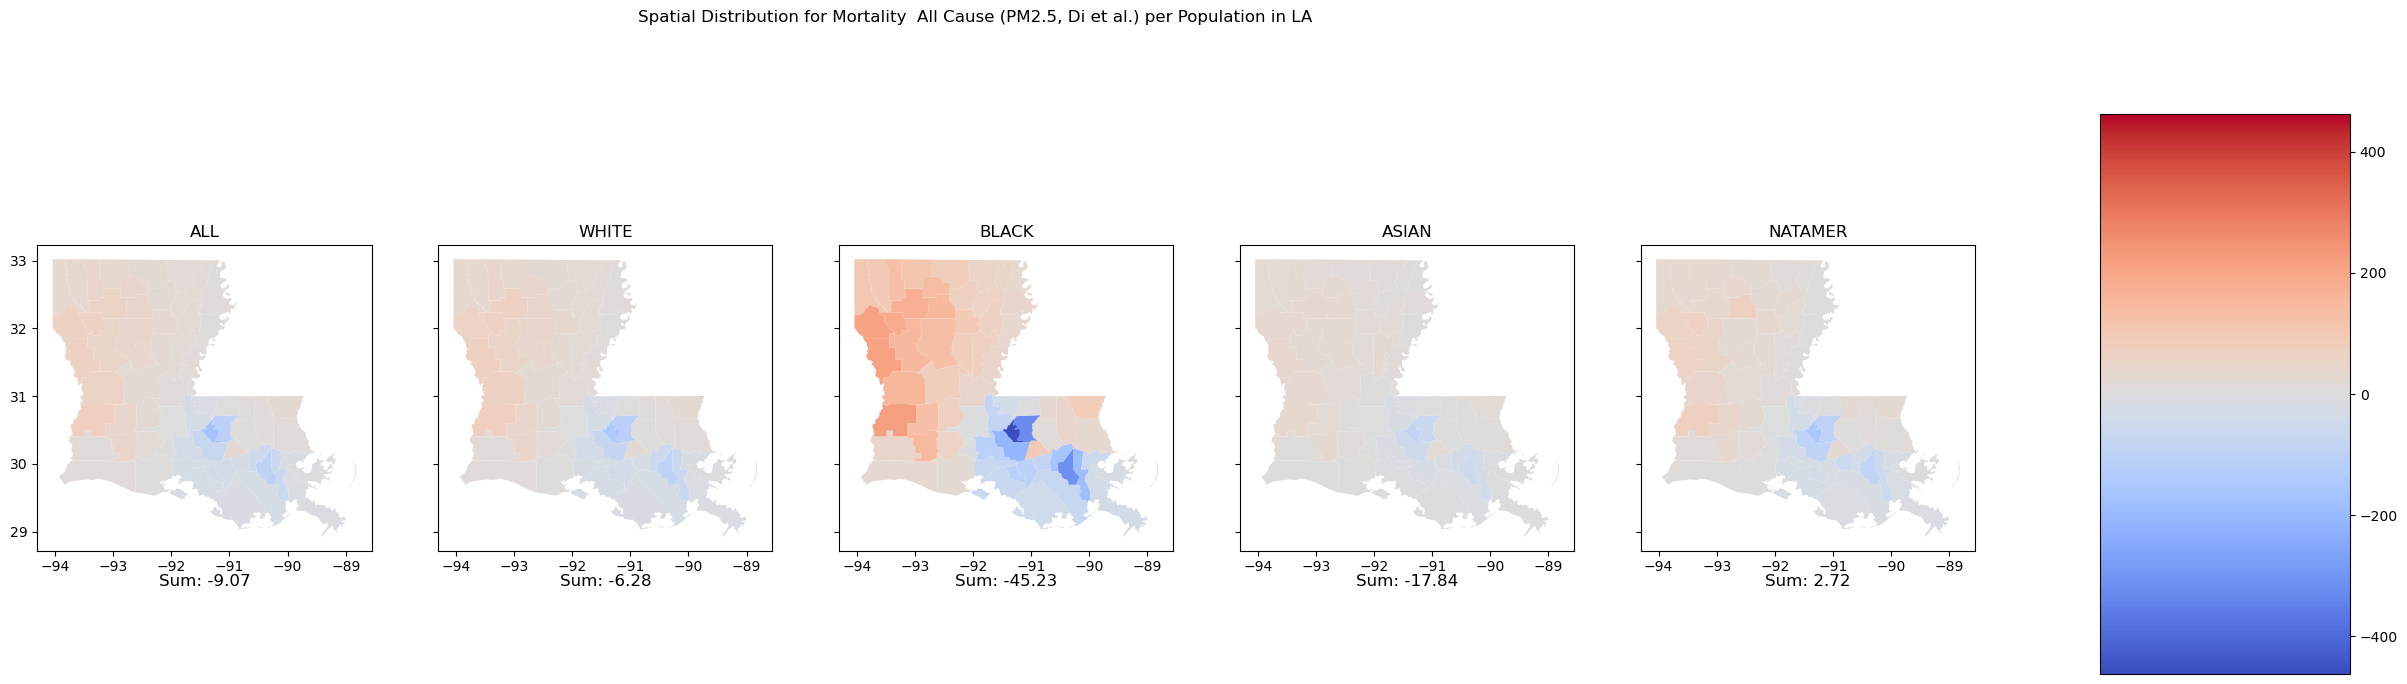

Processing data for: Nation
               Endpoint Pollutant     Author Race STATE_FIPS CNTY_FIPS  Row  \
0  Mortality  All Cause     PM2.5  Di et al.  ALL         01       001    1   
1  Mortality  All Cause     PM2.5  Di et al.  ALL         01       003    3   
2  Mortality  All Cause     PM2.5  Di et al.  ALL         01       005    5   
3  Mortality  All Cause     PM2.5  Di et al.  ALL         01       007    7   
4  Mortality  All Cause     PM2.5  Di et al.  ALL         01       009    9   

   Col      Mean    Population  \
0    1  0.004856   9445.816406   
1    1  0.029840  49344.695312   
2    1  0.001994   5224.887695   
3    1  0.001987   3899.469238   
4    1  0.007056  11738.237305   

                                            geometry  
0  POLYGON ((-86.52469 32.70706, -86.52443 32.707...  
1  POLYGON ((-87.41247 30.57386, -87.41271 30.573...  
2  POLYGON ((-85.13285 31.80037, -85.13283 31.798...  
3  POLYGON ((-87.11632 32.83560, -87.15529 32.835...  
4  POLYGON ((-86.

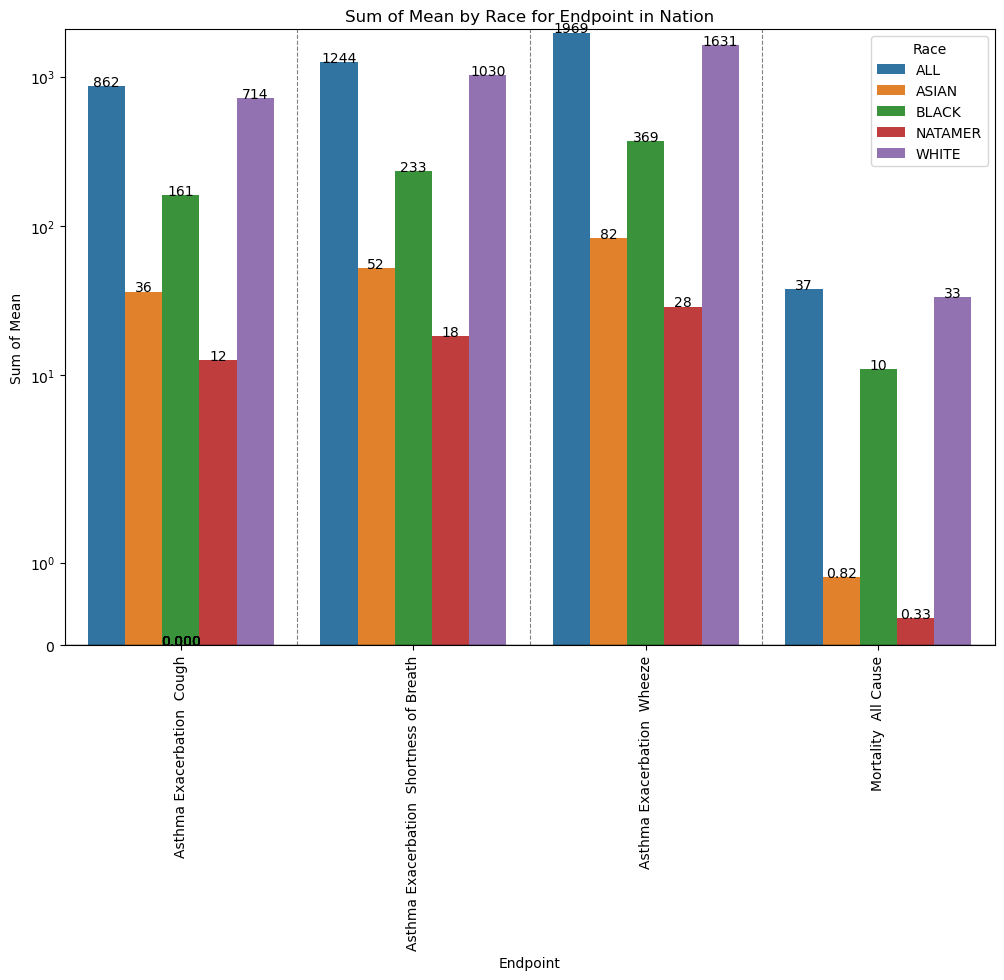

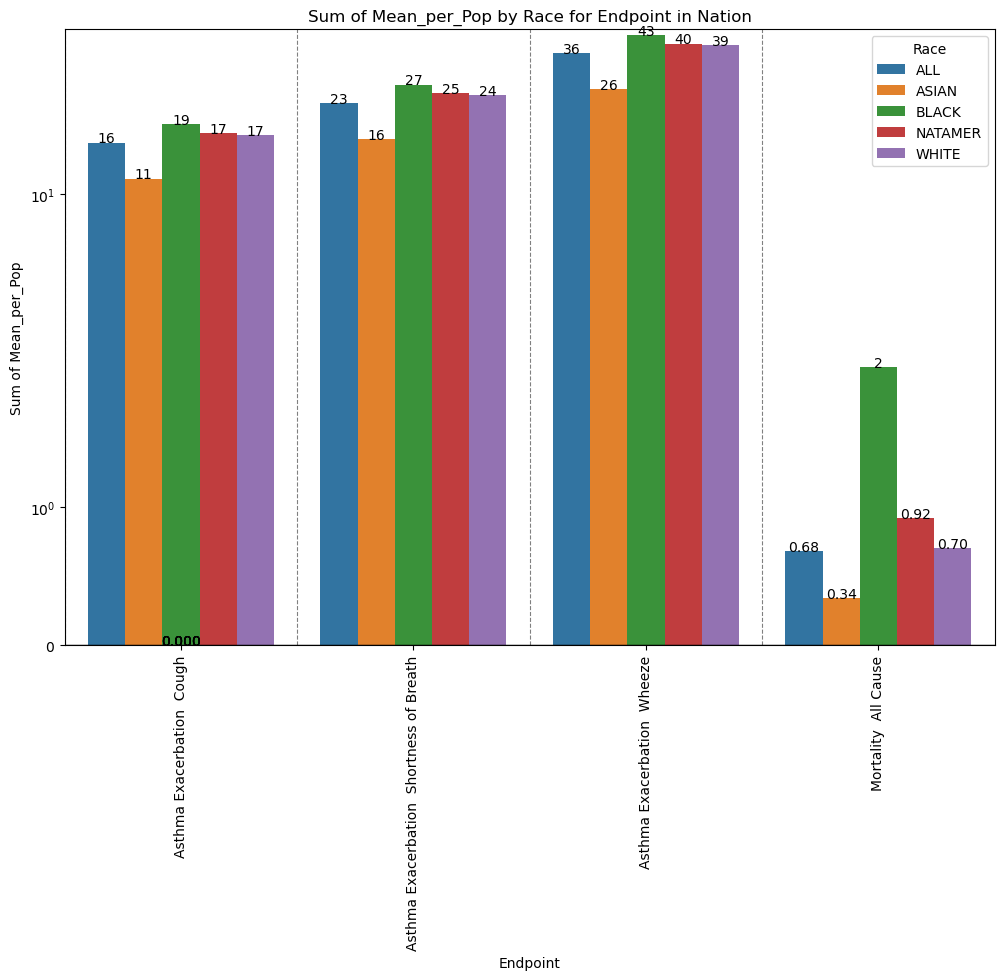

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_92116/2385064045.py:82: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = df[columns].applymap(format_values)


CSV file saved at /Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/BenMAP/batchmode/incidence_results/County_Summary Table: Mean and Mean per Population by Race in Nation.csv


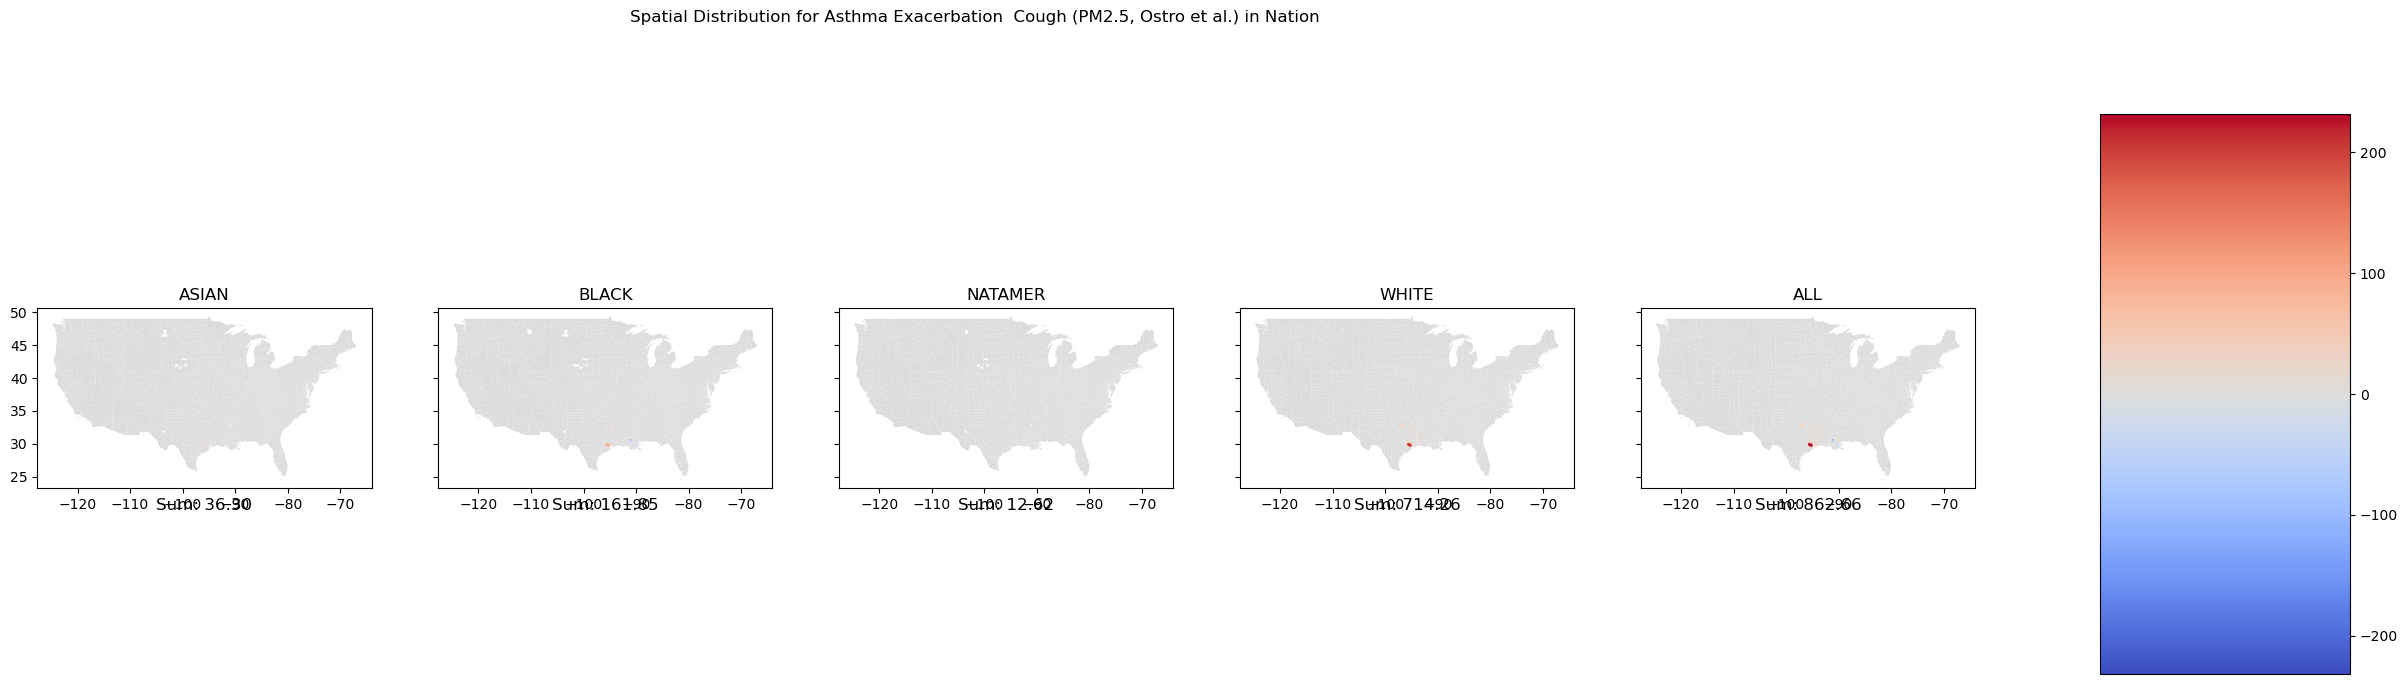

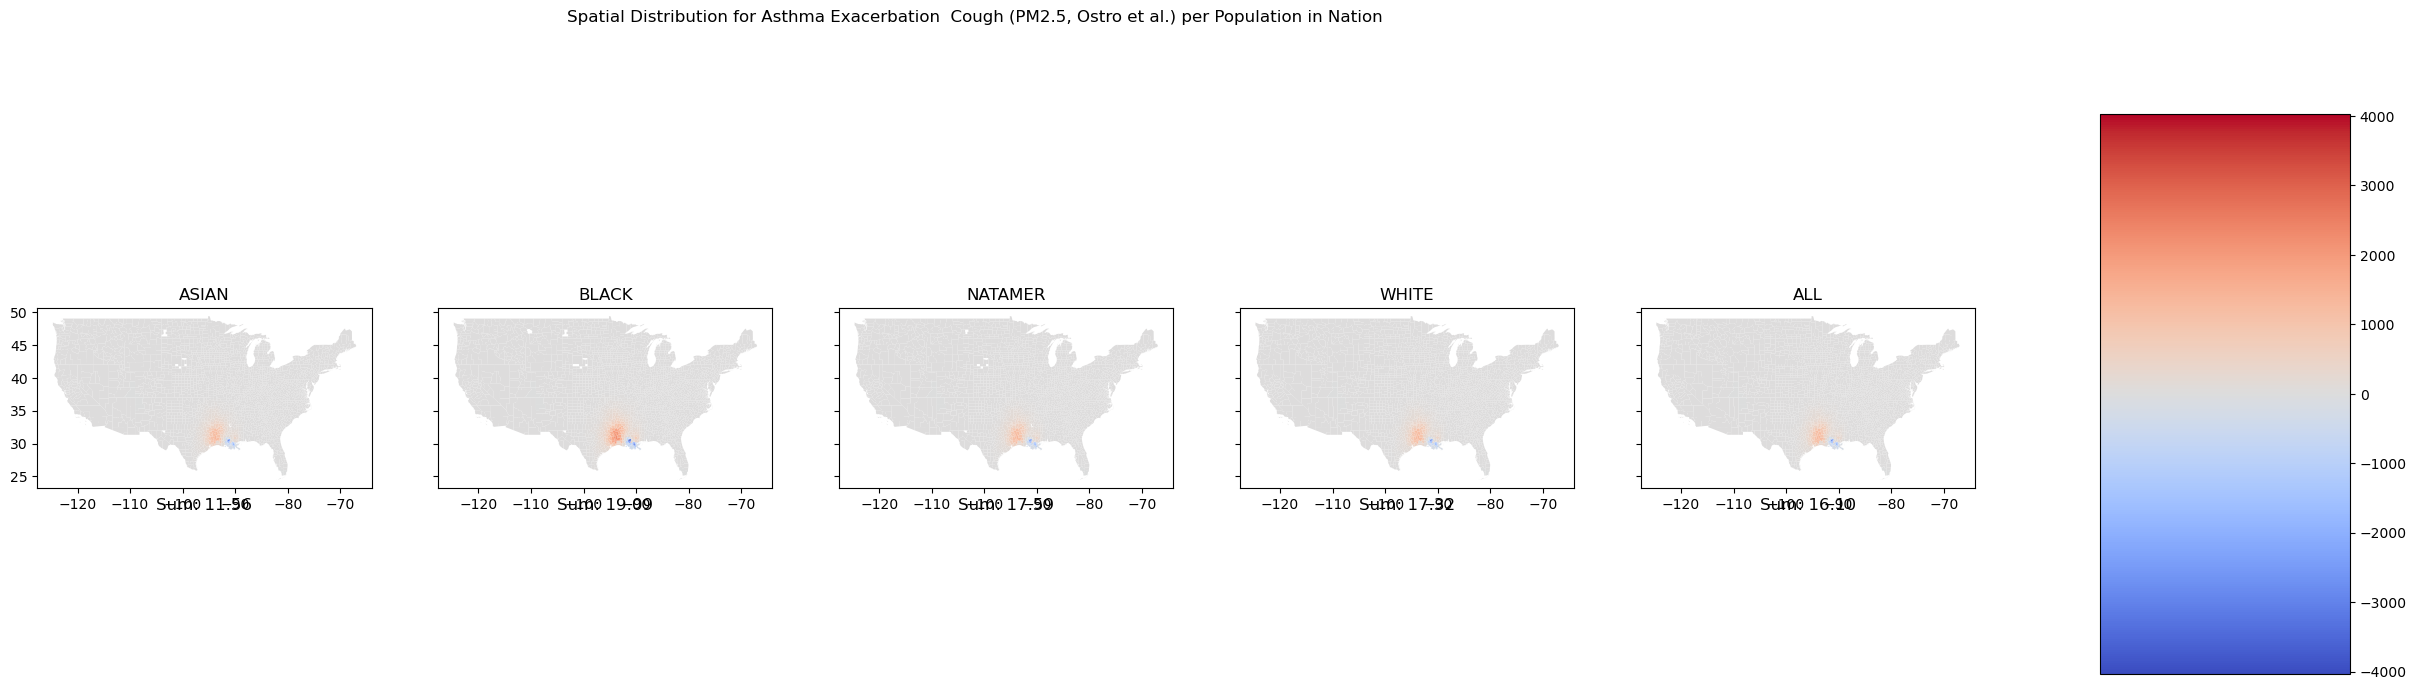

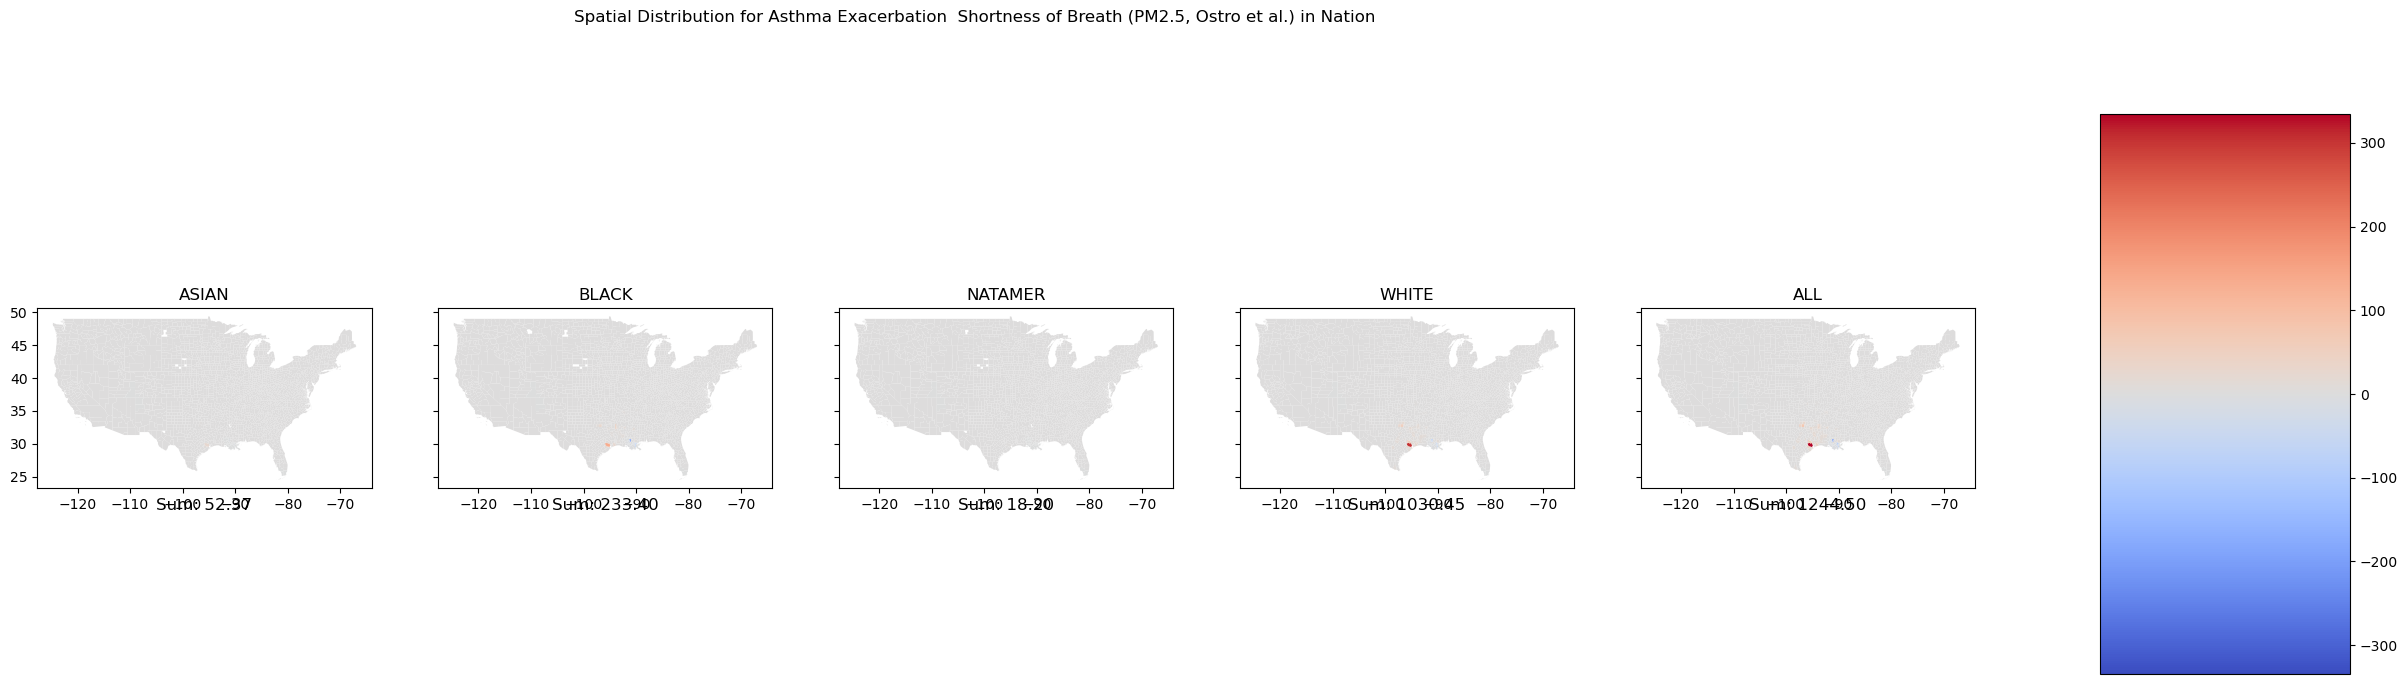

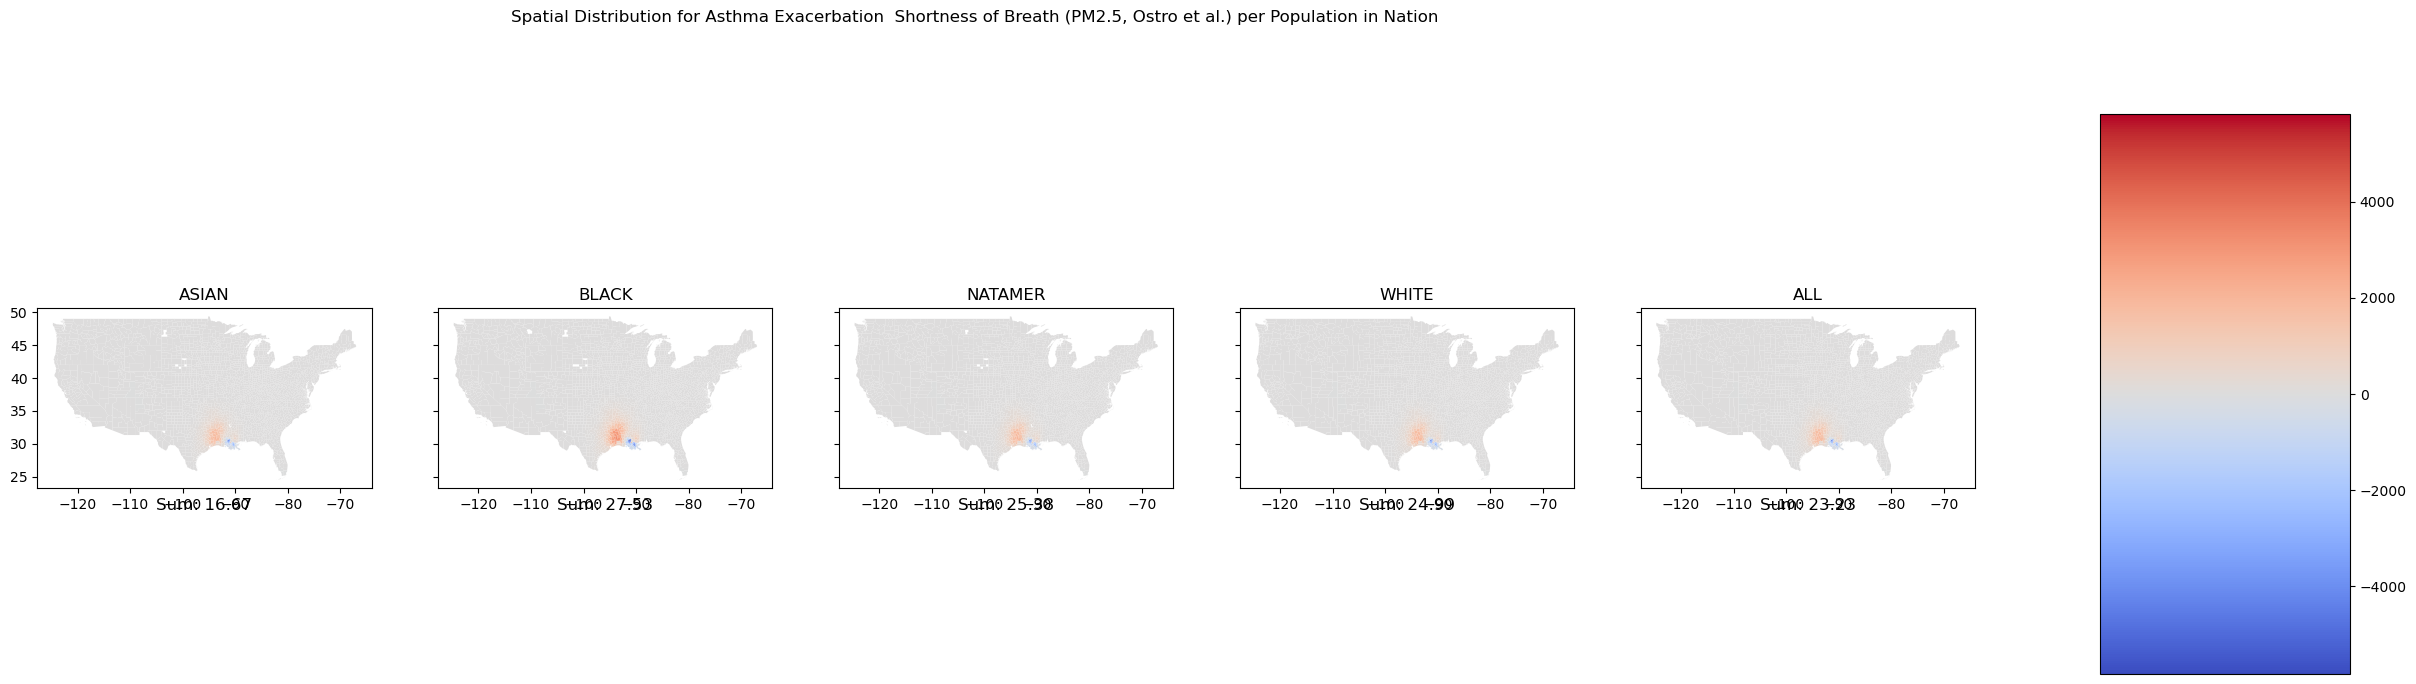

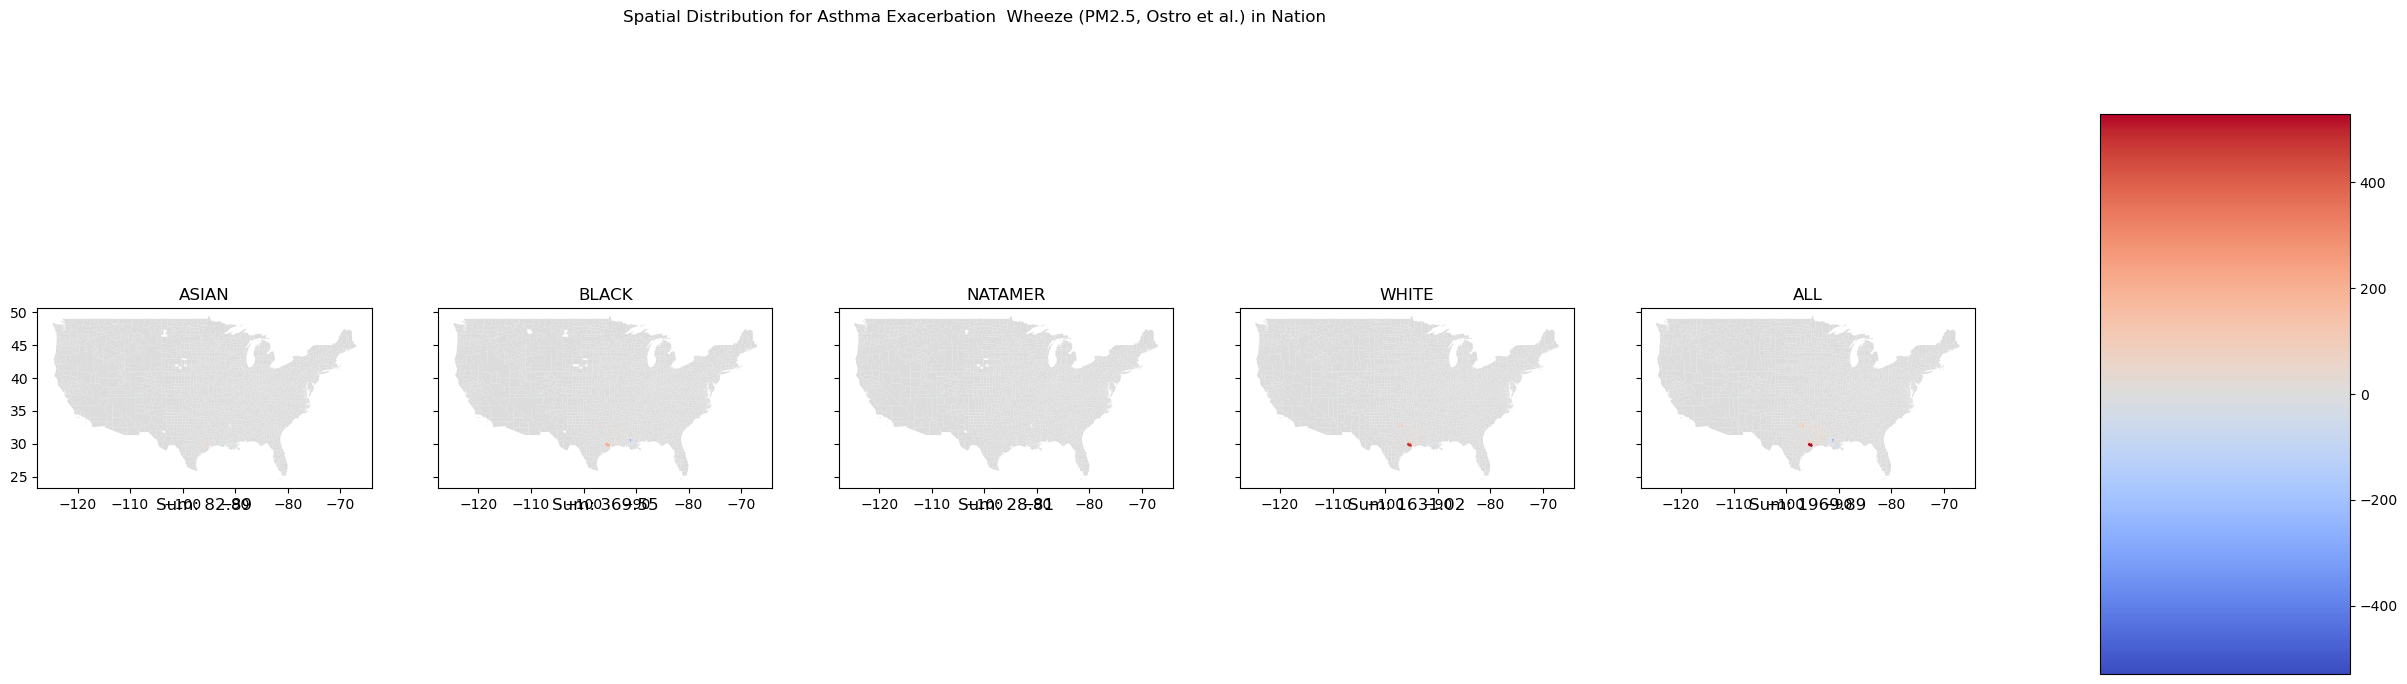

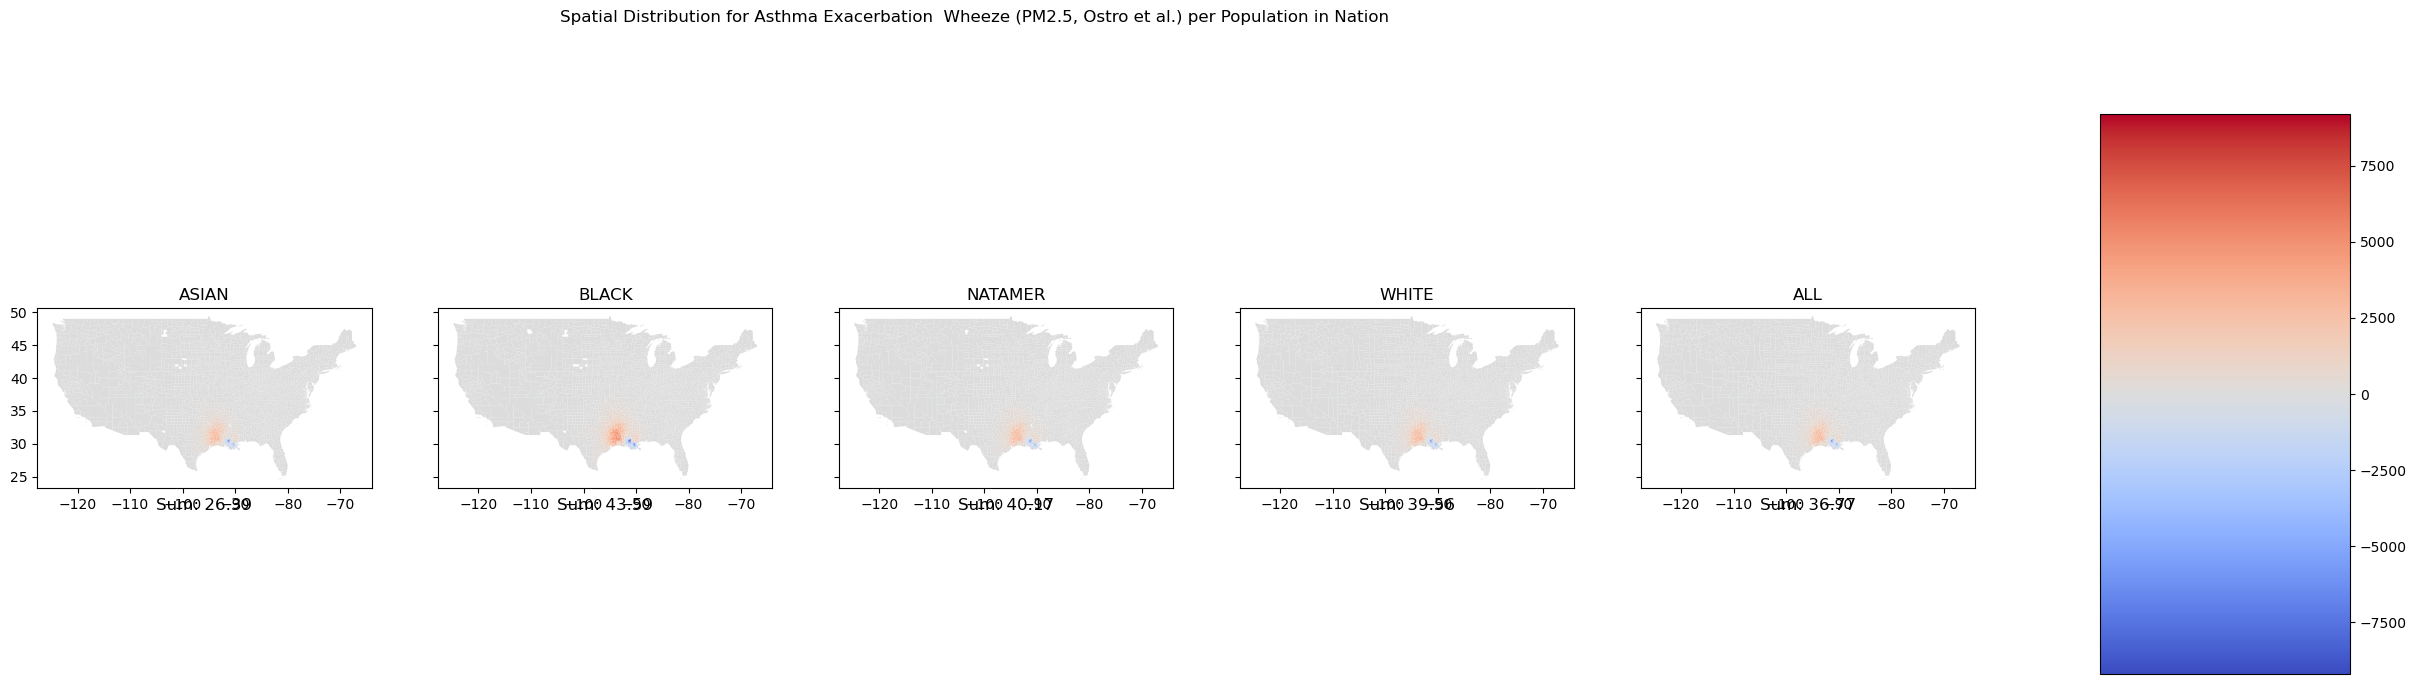

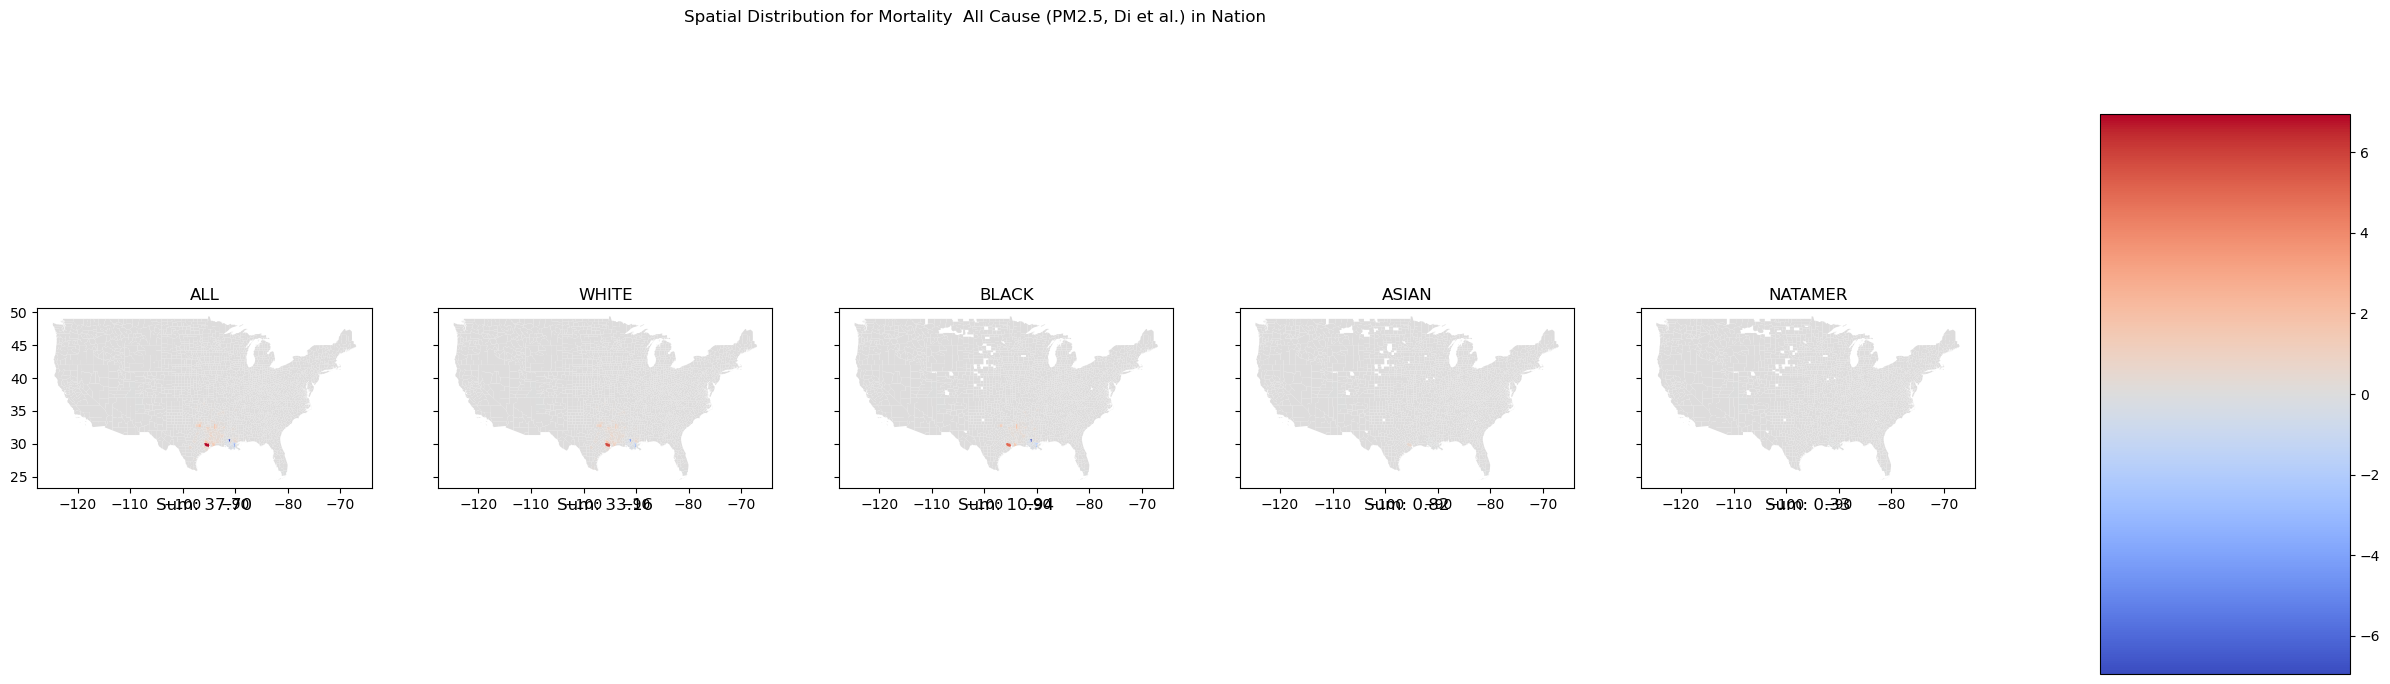

KeyboardInterrupt: 

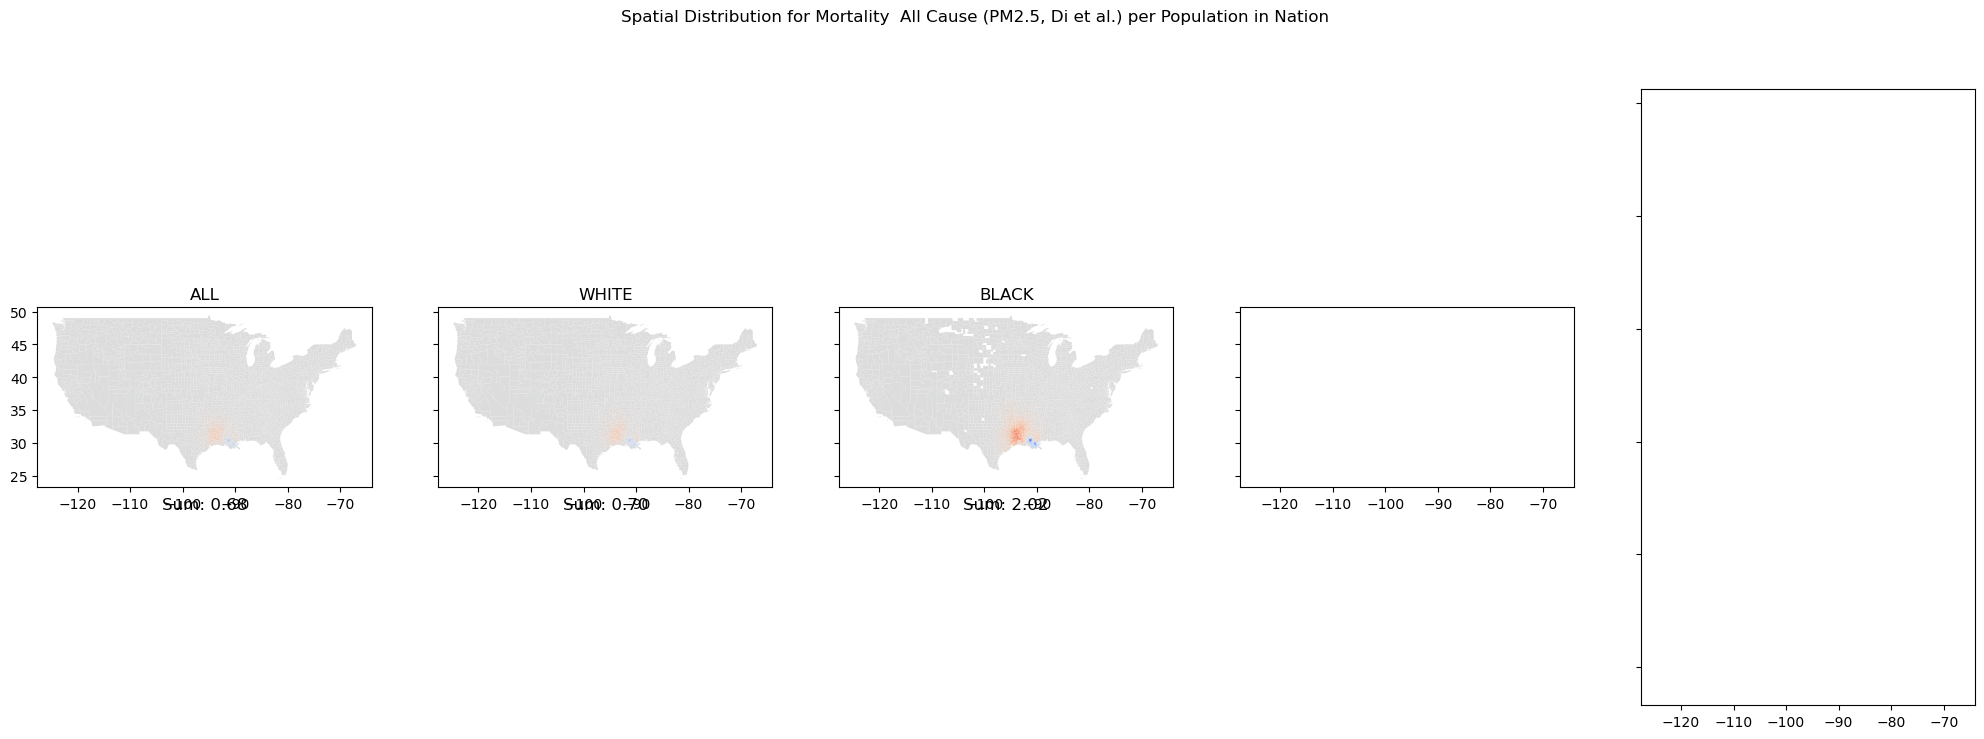

In [2]:

# Define file paths

benmap_output_type =['incidence', 'valuation']

for benmap_output in benmap_output_type:

    benmap_output_file = f'/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/batchmode/APVR/control_la_ccs_county_inmap_2020_pm25-{benmap_output}.csv'
    #benmap_output_file = f"/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/batchmode/APVR/GUI_{benmap_output}_08052024.csv"
    output_dir = f"/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/BenMAP/batchmode/{benmap_output}_results/"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)


    ##############
    # STEP 2: Create final dataframe containing geometry and BenMAP key results ,and compute the normalized Mean with the population (x1e6) for incidence
    ##############

    benmap = pd.read_csv(benmap_output_file)

    # this is only for GUI case
    benmap.rename( columns={"Column":"Col"}, inplace=True)
    benmap['Pollutant'] = 'PM2.5'
 
    # Merge incidence with pop_gdf on the 'Row' and 'Col' columns
    merged_df = benmap.merge(grid_gdf, on=['Row', 'Col'], how='left')

    if benmap_output == 'incidence':
        columns_to_keep = ['Endpoint', 'Pollutant', 'Author', 'Race', 'STATE_FIPS','CNTY_FIPS', 'Row', 'Col', 'Mean', 'Population','geometry']
    else:
        columns_to_keep = ['Endpoint', 'Pollutant', 'Author', 'Race', 'STATE_FIPS','CNTY_FIPS', 'Row', 'Col', 'Mean','geometry']

    final_df = merged_df[columns_to_keep]

    final_df.head()

    ##############
    # STEP 3: Create plots of total health impact (sum the health impact for each endpoint) either for State or Nation and Create map plots of local health impact
    ##############

    # Dictionary to loop over
    regions = {"LA": '22', "Nation": None}

    final_df = gpd.GeoDataFrame(final_df, geometry= "geometry")
    type(final_df)

    # Loop over the regions dictionary and process the data
    for region_name, state_fips in regions.items():
        
        # Subset the final DataFrame based on the chosen state or national
        final_df_subset = subset_data(final_df, state_fips)

        print(f"Processing data for: {region_name}")
        print(final_df_subset.head())

        if benmap_output == 'incidence':
            # Group by ['Endpoint', 'Pollutant', 'Author', 'Race'] and calculate the sum of 'Mean'
            race_grouped_sum = final_df_subset.groupby(['Endpoint', 'Pollutant', 'Author', 'Race']).agg({'Mean': 'sum', "Population":"sum"}).reset_index()

            race_grouped_sum['Mean_per_Pop'] = race_grouped_sum['Mean'] / race_grouped_sum['Population'] * 1000000  # Scale by 1,000,000 for readability

            print("race_grouped_sum", race_grouped_sum.head())

            # Plotting "SUM" barplots by 'Race' for each {endpoint}, {pollutant}, {author}
            plot_bar(race_grouped_sum, "Mean", 'Race', f'Sum of Mean by Race for Endpoint in {region_name}', output_dir)
            plot_bar(race_grouped_sum, "Mean_per_Pop", 'Race', f'Sum of Mean_per_Pop by Race for Endpoint in {region_name}', output_dir)

            # Creating a table to show the values in the barplots
            table_columns = ['Endpoint', 'Race', 'Mean', 'Mean_per_Pop']
        else:
            # Group by ['Endpoint', 'Pollutant', 'Author', 'Race'] and calculate the sum of 'Mean'
            race_grouped_sum = final_df_subset.groupby(['Endpoint', 'Pollutant', 'Author', 'Race']).agg({'Mean': 'sum'}).reset_index()

            # Plotting "SUM" barplots by 'Race' for each {endpoint}, {pollutant}, {author}
            plot_bar(race_grouped_sum, "Mean", 'Race', f'Sum of Mean by Race for Endpoint in {region_name}', output_dir)

            # Creating a table to show the values in the barplots
            table_columns = ['Endpoint', 'Race', 'Mean']

        create_csv(race_grouped_sum, table_columns, f'Summary Table: Mean and Mean per Population by Race in {region_name}', output_dir)


        # Group by ['Endpoint', 'Pollutant', 'Author']
        grouped = final_df_subset.groupby(['Endpoint', 'Pollutant', 'Author'])

        for (endpoint, pollutant, author), group in grouped:

            title_mean = f'Spatial Distribution for {endpoint} ({pollutant}, {author}) in {region_name}'
            plot_spatial_distribution_combined(group, title_mean, "Mean", output_dir)
            
            if benmap_output == 'incidence':
                group['Mean_per_Pop'] = group.apply(lambda row: row['Mean'] / row['Population'] * 1000000, axis=1)  # Scale by 1,000,000 for readability

                title_mean_per_pop = f'Spatial Distribution for {endpoint} ({pollutant}, {author}) per Population in {region_name}'
                plot_spatial_distribution_combined(group, title_mean_per_pop, "Mean_per_Pop", output_dir)